# City effects

## Input data

In [107]:
import geopandas as gpd
from blocksnet.relations import generate_adjacency_graph

blocks_gdf = gpd.read_parquet('./../data/blocks.parquet')[['geometry', 'site_area', 'fsi', 'gsi', 'mxi', 'land_use']]
adjacency_graph = generate_adjacency_graph(blocks_gdf, 10)
blocks_gdf.head()

2025-04-06 18:33:23.292 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_nodes:10 - Generating nodes
2025-04-06 18:33:23.298 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_edges:15 - Generating edges
2025-04-06 18:33:24.642 | SUCCESS  | blocksnet.relations.adjacency.core:generate_adjacency_graph:34 - Adjacency graph successfully generated: 16320 nodes, 16036 edges


,geometry,site_area,fsi,gsi,mxi,land_use
id,,,,,,
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",8.044667e+05,0.054497,0.017345,0.700000,None
1,"POLYGON ((355412.142 6623378.149, 355411.7 662...",2.317313e+04,0.444238,0.217986,0.211541,transport
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",3.630058e+05,0.003234,0.003205,0.700000,recreation
3,"POLYGON ((355099.099 6623847.765, 355074.808 6...",1.964145e+05,0.235746,0.056437,0.660753,residential
4,"POLYGON ((352766.168 6621954.748, 352744.412 6...",1.781752e+06,0.086291,0.025381,0.692085,recreation


## Utils

In [108]:
from blocksnet.analysis.indicators import calculate_development_indicators

LIVING_DEMAND = 30

def calculate_indicators(gdf):
    indicators_df = calculate_development_indicators(gdf)
    indicators_dict = indicators_df.sum().drop(labels=['fsi', 'gsi', 'mxi']).to_dict()
    indicators_dict['population'] = indicators_dict['living_area'] // LIVING_DEMAND
    return indicators_dict

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum

def plot_dicts(dict_a : dict, dict_b : dict):
    # Extract labels and values
    labels = [key.value if isinstance(key, Enum) else key for key in dict_a.keys()]
    values_a =  list(dict_a.values())
    values_b =  list(dict_b.values())

    x = np.arange(len(labels))  # позиции по оси X
    width = 0.35  # ширина столбца

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, values_a, width, label='before', color='skyblue')
    plt.bar(x + width/2, values_b, width, label='after', color='salmon')

    plt.xlabel('Key')
    plt.ylabel('Value')
    plt.title('Comparison')
    plt.xticks(x, labels, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Indicators as is

In [110]:
indicators_before = calculate_indicators(blocks_gdf)
indicators_before

{'site_area': 1360561455.3268828,
 'build_floor_area': 394869149.000342,
 'footprint_area': 103010203.30530432,
 'living_area': 169176178.3799815,
 'non_living_area': 225692970.62036052,
 'population': 5639205.0}

Indicators if we clean the area

In [111]:
from blocksnet.enums import LandUse

scenario_gdf = blocks_gdf.copy()
blocks_ids = blocks_gdf.sample(100).index
scenario_gdf.loc[blocks_ids, 'land_use'] = LandUse.RESIDENTIAL
scenario_gdf.loc[blocks_ids, ['fsi', 'gsi', 'mxi']] = 0

In [112]:
indicators_clean = calculate_indicators(scenario_gdf)
indicators_clean

{'site_area': 1360561455.3268828,
 'build_floor_area': 390688613.62180173,
 'footprint_area': 102116510.07621402,
 'living_area': 167284838.07234856,
 'non_living_area': 223403775.54945317,
 'population': 5576161.0}

Shares comparison

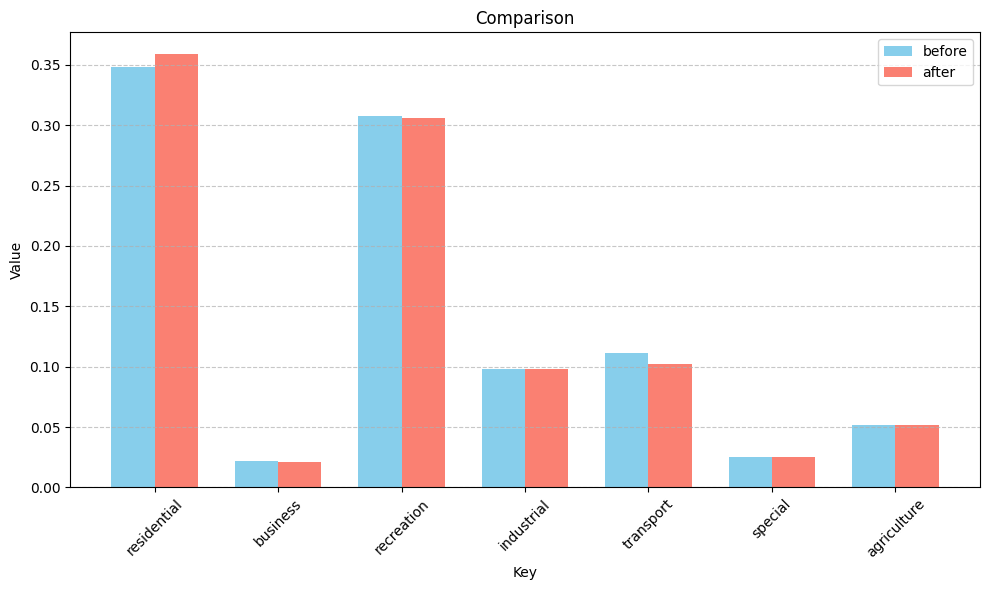

In [113]:
from blocksnet.analysis.land_use import land_use_shares

shares_before = land_use_shares(blocks_gdf)
shares_after = land_use_shares(scenario_gdf)
plot_dicts(shares_before, shares_after)

Calculate new indicators

In [114]:
from blocksnet.machine_learning.regression import DensityRegressor

regressor = DensityRegressor()

Guess the parameters

In [115]:
evaluate_df = regressor.evaluate(scenario_gdf, adjacency_graph)
evaluate_df.head()

2025-04-06 18:33:24.962 | WARNING  | blocksnet.machine_learning.regression.density.schemas:_before_validate:37 - Not valid format. Trying to one hot from land_use column
2025-04-06 18:33:27.743 | INFO     | blocksnet.preprocessing.feature_engineering.core:_calculate_usual_features:34 - Calculating usual features


,fsi,gsi,mxi
id,,,
0,0.124350,0.093895,0.150498
1,0.023492,0.023492,0.046416
2,0.130569,0.096453,0.153888
3,0.293733,0.174963,0.250265
4,0.081888,0.077431,0.128176


In [119]:
scenario_gdf.loc[blocks_ids, ['fsi', 'gsi', 'mxi']] = evaluate_df
indicators_after = calculate_indicators(scenario_gdf)

Compare indicators

In [120]:
indicators_before

{'site_area': 1360561455.3268828,
 'build_floor_area': 394869149.000342,
 'footprint_area': 103010203.30530432,
 'living_area': 169176178.3799815,
 'non_living_area': 225692970.62036052,
 'population': 5639205.0}

In [121]:
indicators_after

{'site_area': 1360561455.3268828,
 'build_floor_area': 392305264.71414924,
 'footprint_area': 103139616.31624463,
 'living_area': 167605614.88891926,
 'non_living_area': 224699649.82523,
 'population': 5586853.0}